# Exploring and Visualizing OpenAQ Data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import openaq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
sns.set_theme(style="darkgrid")

from shapely.geometry import Point

import geopandas as gpd
from geopandas import GeoDataFrame

import geoplot as gplt
import geoplot.crs as gcrs

import fiona

import viz_utils as vu

ERROR 1: PROJ: proj_create_from_database: Open of /home/jovyan/envs/aqproject/share/proj failed


In [2]:
api = openaq.OpenAQ()
resp = api.cities(df=True, limit=10000)

In [3]:
resp.query('city.str.contains("San") and country.str.contains("US")', engine='python')

,country,name,city,count,locations
145,US,Atlanta-Sandy Springs-Marietta,Atlanta-Sandy Springs-Marietta,1904652,13
1383,US,Los Angeles-Long Beach-Santa Ana,Los Angeles-Long Beach-Santa Ana,5563830,32
2030,US,Riverside-San Bernardino-Ontario,Riverside-San Bernardino-Ontario,5439792,42
2096,US,San Antonio,San Antonio,514007,8
2104,US,San Diego-Carlsbad-San Marcos,San Diego-Carlsbad-San Marcos,1007246,11
2110,US,San Francisco Bay Area,San Francisco Bay Area,152929,1
2111,US,San Francisco-Oakland-Fremont,San Francisco-Oakland-Fremont,4657066,15
2113,US,San Jose-Sunnyvale-Santa Clara,San Jose-Sunnyvale-Santa Clara,1312890,8
2116,US,San Juan-Caguas-Guaynabo,San Juan-Caguas-Guaynabo,8475,1
2123,US,San Luis Obispo-Paso Robles,San Luis Obispo-Paso Robles,1613243,34


In [4]:
res = api.locations(city='San Francisco-Oakland-Fremont', df=True)

<AxesSubplot:>

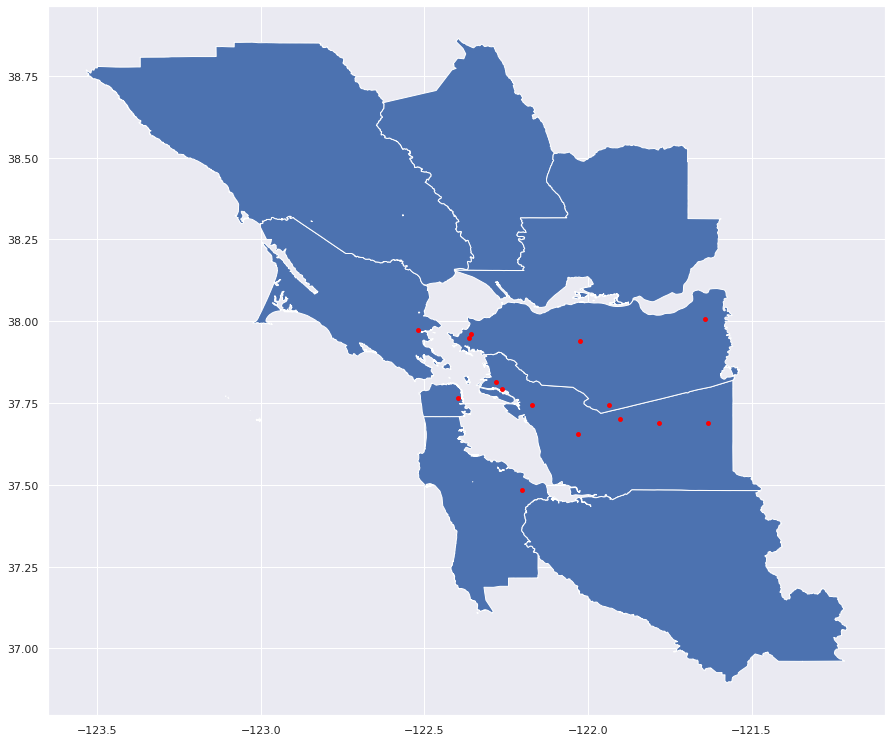

In [5]:
geometry = [Point(xy) for xy in zip(res['coordinates.longitude'], res['coordinates.latitude'])]
gdf = GeoDataFrame(res, geometry=geometry)
world = gpd.read_file("https://data.sfgov.org/api/geospatial/s9wg-vcph?method=export&format=Shapefile")
gdf.plot(ax=world.plot(figsize=(15, 15)), marker='o', color='red', markersize=15)

In [6]:
measure = api.measurements(city='San Francisco-Oakland-Fremont', parameter='pm25', limit=1000, df=True)

# Print out the statistics on a per-location basiss
measure.groupby(['location'])['value'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
Concord,102.0,5.284314,2.364663,-1.0,4.0,5.0,7.0,11.0
Laney College,71.0,5.676056,2.272661,0.0,4.0,6.0,7.0,10.0
Livermore - Rincon,105.0,5.047619,2.486042,0.0,3.0,5.0,7.0,12.0
Oakland,104.0,5.798077,2.096598,1.0,4.0,6.0,7.0,11.0
Oakland West,104.0,4.807692,2.360997,-1.0,3.0,5.0,7.0,11.0
Pleasanton - Owens C,103.0,5.592233,2.749106,-1.0,4.0,5.0,7.0,14.0
Redwood City,103.0,4.106796,3.077154,-3.0,2.0,4.0,5.0,15.0
San Francisco,104.0,5.644231,3.246860,-1.0,3.0,6.0,8.0,17.0
San Pablo - Rumrill,99.0,10.474747,8.175802,3.0,6.0,8.0,11.0,43.0


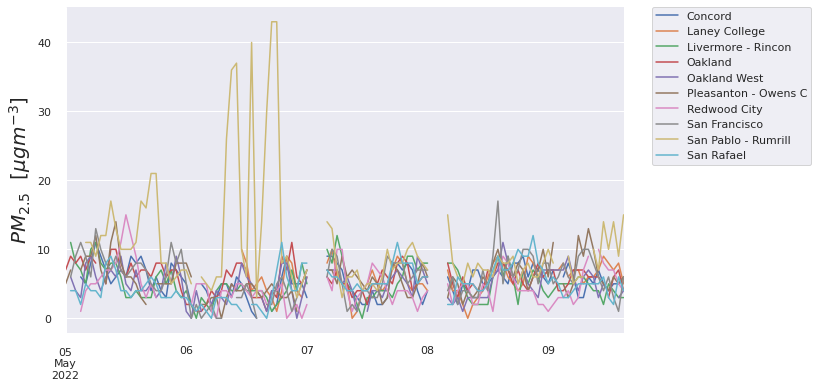

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in measure.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()

    _df.value.plot(ax=ax, label=group)

ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

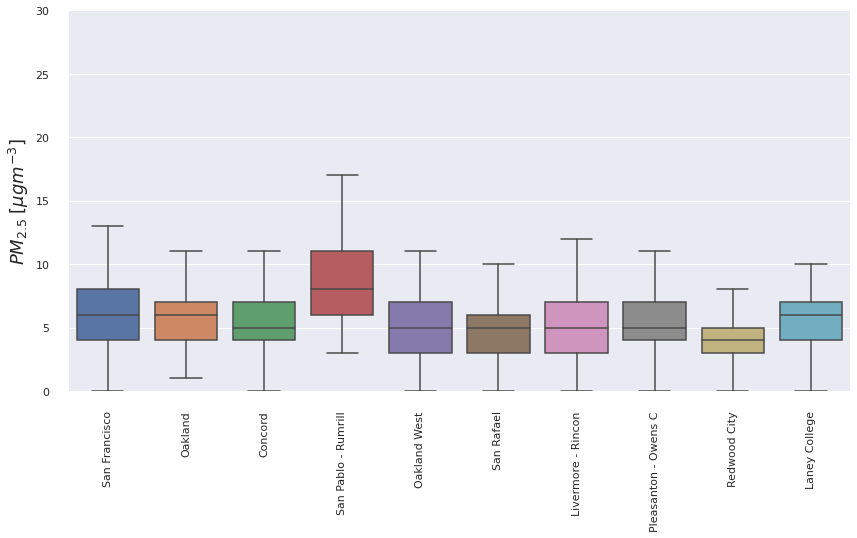

In [8]:
fig, ax = plt.subplots(1, figsize=(14,7))

ax = sns.boxplot(
    x='location',
    y='value',
    data=measure.query("value >= 0.0"),
    fliersize=0,
    palette='deep',
    ax=ax)

ax.set_ylim([0, 30])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

In [9]:
sanfrancisco = api.locations(city='San Francisco-Oakland-Fremont', df=True)


sanfrancisco.iloc[0]


id                                                                    1311
country                                                                 US
city                                         San Francisco-Oakland-Fremont
cities                                     [San Francisco-Oakland-Fremont]
location                                                     Laney College
locations                                                  [Laney College]
sourceName                                                          AirNow
sourceNames                                                       [AirNow]
sourceType                                                      government
sourceTypes                                                   [government]
firstUpdated                                     2016-03-06 19:00:00+00:00
lastUpdated                                      2022-05-09 22:00:00+00:00
parameters                                             [pm25, no2, co, bc]
countsByMeasurement      

In [10]:
dark_day_sf_pm25 = api.measurements(location='San Francisco', parameter='pm25', date_from='2020-09-07', date_to='2020-09-13', df=True, limit=1000)
dark_day_sf_pm25.head()

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-12 17:00:00,San Francisco,pm25,77,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-13 00:00:00+00:00,37.7658,-122.3978
2020-09-12 16:00:00,San Francisco,pm25,78,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 23:00:00+00:00,37.7658,-122.3978
2020-09-12 15:00:00,San Francisco,pm25,77,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 22:00:00+00:00,37.7658,-122.3978
2020-09-12 14:00:00,San Francisco,pm25,83,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 21:00:00+00:00,37.7658,-122.3978
2020-09-12 13:00:00,San Francisco,pm25,87,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-12 20:00:00+00:00,37.7658,-122.3978


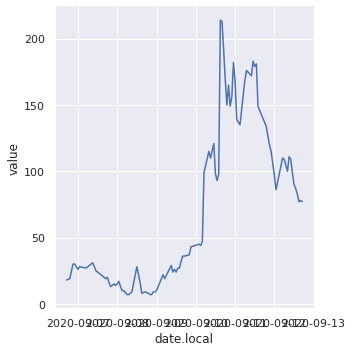

In [11]:
g = sns.relplot(x=dark_day_sf_pm25.index, y='value', kind='line', data=dark_day_sf_pm25)
#g.set(xticks=range(len(dark_day_sf_pm25.index)+1))

In [12]:
dark_max = dark_day_sf_pm25[dark_day_sf_pm25.value == dark_day_sf_pm25.value.max()]
dark_max

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-10 15:00:00,San Francisco,pm25,214,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-10 22:00:00+00:00,37.7658,-122.3978


In [13]:
test = api.measurements(city='San Francisco-Oakland-Fremont', date_from='2020-09-07', date_to='2020-09-08', df=True, limit=1000)
test = test[test['parameter'] == 'pm25']
test = test[test['date.utc'] == '2020-09-07 13:00:00+00:00']
test

,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,
2020-09-07 06:00:00,Concord,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.938300,-122.025000
2020-09-07 06:00:00,Laney College,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.793624,-122.263376
2020-09-07 06:00:00,Livermore - Rincon,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.687526,-121.784217
2020-09-07 06:00:00,Redwood City,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.482800,-122.202200
2020-09-07 06:00:00,Oakland West,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.814800,-122.282402
2020-09-07 06:00:00,San Rafael,pm25,18.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.972200,-122.518900
2020-09-07 06:00:00,Oakland,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.743061,-122.169907
2020-09-07 06:00:00,Pleasanton - Owens C,pm25,32.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.701222,-121.903019
2020-09-07 06:00:00,San Pablo - Rumrill,pm25,16.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.960400,-122.357100


In [14]:
geometry = [Point(xy) for xy in zip(test['coordinates.longitude'], test['coordinates.latitude'])]
gdf = GeoDataFrame(test, geometry=geometry)

gdf


,location,parameter,value,unit,country,city,date.utc,coordinates.latitude,coordinates.longitude,geometry
date.local,,,,,,,,,,
2020-09-07 06:00:00,Concord,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.938300,-122.025000,POINT (-122.02500 37.93830)
2020-09-07 06:00:00,Laney College,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.793624,-122.263376,POINT (-122.26338 37.79362)
2020-09-07 06:00:00,Livermore - Rincon,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.687526,-121.784217,POINT (-121.78422 37.68753)
2020-09-07 06:00:00,Redwood City,pm25,30.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.482800,-122.202200,POINT (-122.20220 37.48280)
2020-09-07 06:00:00,Oakland West,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.814800,-122.282402,POINT (-122.28240 37.81480)
2020-09-07 06:00:00,San Rafael,pm25,18.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.972200,-122.518900,POINT (-122.51890 37.97220)
2020-09-07 06:00:00,Oakland,pm25,21.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.743061,-122.169907,POINT (-122.16991 37.74306)
2020-09-07 06:00:00,Pleasanton - Owens C,pm25,32.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.701222,-121.903019,POINT (-121.90302 37.70122)
2020-09-07 06:00:00,San Pablo - Rumrill,pm25,16.0,b'\xc2\xb5g/m\xc2\xb3',US,San Francisco-Oakland-Fremont,2020-09-07 13:00:00+00:00,37.960400,-122.357100,POINT (-122.35710 37.96040)


Text(0.5, 1.0, 'Bay Area pm25 on ')

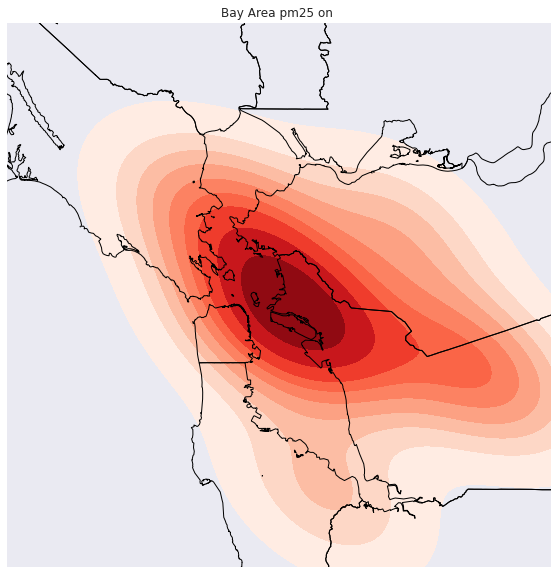

In [15]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.kdeplot(
    gdf,
    cmap='Reds',
    projection=proj,
    shade=True, thresh=0.05,
    ax=ax1
)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [16]:
USlocs = api.locations(country='US', df=True, limit=10000)

USlocs.head()

,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
0,212,US,Fort Smith,[Fort Smith],ROLAND,[ROLAND],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 22:00:00+00:00,"[o3, no2, pm25, pm10]","[{'parameter': 'o3', 'count': 71263}, {'parame...",204898,35.408138,-94.524414
1,213,US,TWIN FALLS,[TWIN FALLS],Twin Falls PM25,"[Twin Falls 1405 TEOM, Twin Falls PM25]",AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 22:00:00+00:00,[pm25],"[{'parameter': 'pm25', 'count': 104039}]",104039,42.565089,-114.494717
2,215,US,TUSCOLA,[TUSCOLA],Unionville,[Unionville],AirNow,[AirNow],government,[government],2016-03-11 22:00:00+00:00,2022-05-09 22:00:00+00:00,[o3],"[{'parameter': 'o3', 'count': 80418}]",80418,43.610000,-83.360000
3,216,US,South Bend-Mishawaka,[South Bend-Mishawaka],South Bend-Shields D,[South Bend-Shields D],AirNow,[AirNow],government,[government],2016-03-06 19:00:00+00:00,2022-05-09 22:00:00+00:00,"[pm25, no2, o3]","[{'parameter': 'pm25', 'count': 40366}, {'para...",212905,41.696700,-86.214700
4,218,US,Chicago-Naperville-Joliet,[Chicago-Naperville-Joliet],Ogden Dunes,[Ogden Dunes],AirNow,[AirNow],government,[government],2016-03-13 05:00:00+00:00,2022-05-09 22:00:00+00:00,"[pm25, o3]","[{'parameter': 'pm25', 'count': 1}, {'paramete...",89451,41.617500,-87.199200


In [17]:
bay_area_locs = vu.location_filter(USlocs, minlat = 36., minlon = -123.5, maxlat=39., maxlon = -121, starttime='2020-09-07', endtime='2020-09-13') 
bay_area_locs.head()

,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
176,627,US,Sacramento--Arden-Arcade--Roseville,[Sacramento--Arden-Arcade--Roseville],Woodland,[Woodland],AirNow,[AirNow],government,[government],2016-03-11 15:00:00+00:00,2022-05-09 22:00:00+00:00,"[o3, pm25]","[{'parameter': 'o3', 'count': 84719}, {'parame...",171979,38.661239,-121.732683
183,635,US,Vallejo-Fairfield,[Vallejo-Fairfield],Vacaville,[Vacaville],AirNow,[AirNow],government,[government],2016-03-11 15:00:00+00:00,2022-05-09 22:00:00+00:00,"[o3, pm25]","[{'parameter': 'o3', 'count': 85306}, {'parame...",172171,38.356556,-121.949853
200,655,US,Sacramento--Arden-Arcade--Roseville,[Sacramento--Arden-Arcade--Roseville],Auburn,[Auburn],AirNow,[AirNow],government,[government],2016-03-11 15:00:00+00:00,2022-05-09 22:00:00+00:00,"[pm25, o3]","[{'parameter': 'pm25', 'count': 84799}, {'para...",168609,38.935680,-121.099590
211,671,US,Vallejo-Fairfield,[Vallejo-Fairfield],Rio Vista,[Rio Vista],AirNow,[AirNow],government,[government],2016-03-11 15:00:00+00:00,2022-05-09 22:00:00+00:00,[pm25],"[{'parameter': 'pm25', 'count': 47098}]",47098,38.167297,-121.688561
248,793,US,Stockton,[Stockton],TracyAP,[TracyAP],AirNow,[AirNow],government,[government],2016-03-10 07:00:00+00:00,2022-05-09 22:00:00+00:00,"[no2, o3, pm25, pm10]","[{'parameter': 'no2', 'count': 64802}, {'param...",310551,37.682500,-121.440600


In [20]:
## This Needs Work
def param_data_per_loc_for_period(loc_table, start_date= '2020-09-07', end_date='2020-09-13', param='pm25', limit=1000, interpolate=True):
    api = openaq.OpenAQ()
    city_list = loc_table.reset_index()
    dark_days_data = {}
    for index, row in city_list.iterrows():
        location = row['location']
        coords = (row['coordinates.longitude'], row['coordinates.latitude'])
        if row['parameters'].count(param) == 0:
            continue
        try:
            table = api.measurements(location=location, parameter=param, 
                                 date_from= start_date, date_to=end_date, df=True, limit=limit)
            table = table.reset_index()
            date_vals = dict(list(zip(table['date.local'], table['value'])))
            if dark_days_data.has_key(location):
                location = location +'_'+ str(np.random.randint(0,1000000))
            dark_days_data[location] = list()
            dark_days_data[location].append(coords)
            dark_days_data[location].append(date_vals)
        except:
            continue
    print(list(dark_days_data.keys()))
    df = pd.DataFrame.from_dict(dark_days_data[list(dark_days_data.keys())[0]][1], orient='index', columns=[list(dark_days_data.keys())[0]])
    for key in dark_days_data.keys():
        df2 = pd.DataFrame.from_dict(dark_days_data[key][1], orient='index', columns=[key])
        df = pd.concat([df, df2], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    if interpolate:
        df = df.interpolate(method='linear', limit_direction='forward', axis=0)
        df = df.interpolate(method='linear', limit_direction='backward', axis=0)
    return df


In [21]:
vu.param_data_per_loc_for_period(bay_area_locs, start_date= '2020-09-07', end_date='2020-09-13', param='pm25', limit=1000, interpolate=True)

IndexError: list index out of range

In [ ]:
df.head()

In [ ]:
df.size

In [ ]:
cities_coordinates = vu.cities_coords(bay_area_locs, df)
cities_coordinates

In [ ]:
temp = cities_coordinates.set_index([0])
for i in range(df.shape[0]):
    dftemp =  pd.DataFrame(df.iloc[i])
    temp = pd.concat([temp, dftemp], axis=1)
bay_area_dark_days_data = temp
bay_area_dark_days_data 


In [ ]:
bay_area_dark_days_data_text = bay_area_dark_days_data
bay_area_dark_days_data_text.columns = bay_area_dark_days_data_text.columns.astype(str)
bay_area_dark_days_data_text.to_file('bayareadarkdays.geojson', driver='GeoJSON')  

In [ ]:
bay_data = gpd.read_file('bayareadarkdays.geojson')

In [ ]:
col_list = bay_data.columns
dark_day_cols = [col for col in bay_data.columns if '2020-09-09' in col]
dark_max = [col for col in bay_data.columns if '2020-09-10 15:00:00' in col]

In [ ]:
lats = []
lons = []
for i in range(len(coord_list)):
    lats.append(coord_list[i][1])
    lons.append(coord_list[i][0])
    
data= pd.DataFrame()
data['Lat'] = lats
data['Lon'] = lons

In [ ]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(20, 10))
ax1 = plt.subplot(121, projection=proj)
ax2 = plt.subplot(122, projection=proj)


# gplt.kdeplot(
#     bay_data[['index', 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True, bw=1,
#     ax=ax1, n_levels=20, weights=bay_data[col_list[1]]
# )
gplt.pointplot(bay_data, projection=proj, hue=col_list[1], legend=True,scale=col_list[1], limits=(0, 341), cmap='inferno_r', ax=ax1, vmin=0, vmax=340)
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

# gplt.kdeplot(
#     bay_data[['index', 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True, bw=1,
#     ax=ax2, n_levels=20, weights=bay_data[dark_max[0]]
# )
gplt.pointplot(bay_data, projection=proj, hue=dark_max[0], legend=True,scale=dark_max[0], limits=(10, 100), cmap='inferno_r', ax=ax2)
gplt.polyplot(world, zorder=1, ax=ax1)
# ax1.axis(xmin=-50000,xmax=60000, ymin=-70000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")
gplt.polyplot(world, zorder=1, ax=ax2)
# ax2.axis(xmin=-50000,xmax=60000, ymin=-70000, ymax=50000)
ax2.set_title("Bay Area pm25 on ")

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline


def aqviz(coords, val, title):
    # https://stackoverflow.com/questions/26872337/how-can-i-get-my-contour-plot-superimposed-on-a-basemap
    # set up plot
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, frame_on=False)

    # grab data
    data['Z'] = bay_data[dark_max[0]]

    norm = Normalize()

    # define map extent
    lllon = min(data.Lon.values)
    lllat = min(data.Lat.values)
    urlon = max(data.Lon.values)
    urlat = max(data.Lat.values)


    # Set up Basemap instance
    m = Basemap(
        projection = 'merc',
        llcrnrlon = lllon, llcrnrlat = lllat, urcrnrlon = urlon, urcrnrlat = urlat,
        resolution='i')

    # transform lon / lat coordinates to map projection
    data['projected_lon'], data['projected_lat'] = m(*(data.Lon.values, data.Lat.values))

    # # grid data
    numcols, numrows = 1000, 1000
    xi = np.linspace(data['projected_lon'].min(), data['projected_lon'].max(), numcols)
    yi = np.linspace(data['projected_lat'].min(), data['projected_lat'].max(), numrows)
    xi, yi = np.meshgrid(xi, yi)

    # # interpolate
    x, y, z = data['projected_lon'].values, data['projected_lat'].values, data.Z.values
    zi = griddata((x, y), z, (xi, yi))

    # # draw map details
    m.drawmapboundary(fill_color = 'white')
    m.fillcontinents(color='#C0C0C0', lake_color='#7093DB')
    m.drawcountries(
        linewidth=.75, linestyle='solid', color='#000073',
        antialiased=True,
        ax=ax, zorder=3)
    m.drawcoastlines()


    # # contour plot
    con = m.pcolormesh(xi, yi, zi, zorder=20, alpha=0.6, cmap='inferno_r', vmin=0, vmax=341)
    # scatter plot
    m.scatter(
        data['projected_lon'],
        data['projected_lat'],
        color='#545454',
        edgecolor='#ffffff',
        alpha=.75,
        ax=ax,
        vmin=zi.min(), vmax=zi.max(), zorder=20)

    # # add colour bar and title
    # # add colour bar, title, and scale
    cbar = plt.colorbar(orientation='vertical', fraction=.057, pad=0.05)
    cbar.set_label("Mean Rainfall - mm")

    # m.drawmapscale(
    #     24., -9., 28., -13,
    #     100,
    #     units='km', fontsize=10,
    #     yoffset=None,
    #     barstyle='fancy', labelstyle='simple',
    #     fillcolor1='w', fillcolor2='#000000',
    #     fontcolor='#000000',
    #     zorder=5)

aqviz(data, dark_max[0], "Title")
# # plt.title("Mean Rainfall")
# plt.show()

In [ ]:
data

In [ ]:
proj = gcrs.AlbersEqualArea(central_latitude=37.8711428, central_longitude=-122.3714777)
fig= plt.figure(figsize=(10, 10))
ax1 = plt.subplot(111, projection=proj)

gplt.pointplot(bay_data, projection=proj, hue=dark_max[0], legend=True,scale=dark_max[0], limits=(10, 100), cmap='inferno_r', ax=ax1)
# gplt.kdeplot(
#     bay_data[['index',col_list[1], 'geometry']],
#     cmap='Reds',
#     projection=proj,
#     shade=True,
#     ax=ax1, n_levels=20
# )
gplt.polyplot(world, zorder=1, ax=ax1)
ax1.axis(xmin=-50000,xmax=60000, ymin=-60000, ymax=50000)
ax1.set_title("Bay Area pm25 on ")

In [ ]:
bay_data[['index',col_list[1], 'geometry']]

In [ ]:
bay_data[['index',dark_max[0], 'geometry']]